In [1]:
#!python -m spacy download en_core_web_md

In [2]:
#!pip install flair

In [3]:
#!pip install pyspellchecker

In [4]:
#!pip install --upgrade setuptools wheel

In [5]:
#!pip install top2vec

In [6]:
#!pip install top2vec[sentence_encoders]

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import spacy
import contractions
import nltk
import re
from nltk import bigrams, trigrams, word_tokenize
from collections import Counter
import swifter
import itertools
from flair.models import SequenceTagger
from flair.data import Sentence
import numpy as np
import random
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import chardet
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import Word2Vec
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances
from top2vec import Top2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


C:\Users\subbu\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\subbu\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\subbu\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
# Get all the html file names
html_files = glob.glob('*.html')

In [3]:
print(f'Number of html_files in the current directory: {len(html_files)}')

Number of html_files in the current directory: 1458


In [4]:
jobs_data = {}

In [5]:
encoding_scheme = {}

In [6]:
# Finding the encoding for each of the html file.
for html_file in html_files:
    
    # Open the file in binary mode
    with open(html_file, 'rb') as f:
        data = f.read()

    # Detect the encoding
    result = chardet.detect(data)
    encoding = result['encoding']

    # Decode the HTML file using the found encoding.
    decoded_html = data.decode(encoding)
    
    # Store the encoding scheme for each html file
    encoding_scheme[html_file] = encoding

In [7]:
# create a set to hold the unique parent tags
unique_parent_tags = {}

for html_file in html_files:
    # Open and read the html file
    with open(html_file, 'rb') as file:
        data = file.read()

    # Get html content
    content = data.decode(encoding_scheme[html_file])
        
    # Parse the data using BeautifulSoup html parser
    soup = BeautifulSoup(content, 'html.parser')

    # Get html body
    body = soup.body

    # get all tags within the body
    tags = body.find_all()

    # iterate over each tag
    for tag in tags:
        # 'tag.parent' will be a tag object
        if tag.parent is not None:
            if html_file in unique_parent_tags:
                unique_parent_tags[html_file].add(tag.parent.name)
            else:
                tmp = set()
                tmp.add(tag.parent.name)
                unique_parent_tags[html_file] = tmp

In [8]:
unique_parent_tags

{'001b92395ed0fb62.html': {'body', 'p', 'ul'},
 '00321a48d04fe754.html': {'body', 'ul'},
 '0079c11b2611349f.html': {'body', 'p', 'ul'},
 '007d9d7b5c09d820.html': {'body', 'h1', 'ul'},
 '00bf37ae19c7dfd7.html': {'body', 'div', 'h2', 'h3', 'p', 'ul'},
 '0125eabc844281c9.html': {'body', 'div', 'ul'},
 '014ae4dbded805d2.html': {'body'},
 '014ea972a4aa9812.html': {'body', 'div', 'p', 'ul'},
 '0179ea131f141400.html': {'body', 'div', 'p', 'ul'},
 '018866568cd5a0b0.html': {'body', 'p', 'ul'},
 '01aa3fd02a66fc1d.html': {'body', 'div', 'p', 'ul'},
 '01bd31cf3814dee3.html': {'body', 'div', 'li', 'ul'},
 '0203a50423c1dff3.html': {'body', 'ul'},
 '025f464c00c43f58.html': {'body', 'div', 'h2', 'ul'},
 '032a60df9899fe1c.html': {'body', 'p', 'ul'},
 '03b7844b77344288.html': {'body', 'div', 'h2', 'p', 'ul'},
 '03db5efbdebb59a8.html': {'body', 'ul'},
 '0410b4cd5db34fec.html': {'body', 'div', 'p', 'ul'},
 '04186a90ce9af7e3.html': {'body'},
 '04817d18faa6531c.html': {'body'},
 '0488045ed4473017.html': {'b

In [9]:
# After analyzing the html files, many of the job postings have the job requirements and skill
# sets enclosed with li tags. Some of them do not have job requirements listed under li tags
# but under different parent tag. Some of them(138 files) do not have li tags at all in 
# their html body.

In [10]:
for html_file in html_files:
    # Open and read the html file
    with open(html_file, 'rb') as file:
        data = file.read()
    
    # Get html content
    content = data.decode(encoding_scheme[html_file])

    # Parse the data using BeautifulSoup html parser
    soup = BeautifulSoup(content, 'html.parser')

    # Extract the job titles    
    job_title = soup.title.string

    # Get html body text.
    body_text = soup.body.text

    # Save job title and body texts for each html file
    jobs_data[html_file] = [job_title, body_text]

In [11]:
# Create a dataframe named job_postings from the required parsed data
job_postings = pd.DataFrame.from_dict(jobs_data, orient='index', columns=['job_title', 'job_desc'])

In [12]:
job_postings.reset_index(inplace=True)

In [13]:
job_postings.head()

index                                          job_title  \
0  001b92395ed0fb62.html                   Data Scientist - Beavercreek, OH   
1  00321a48d04fe754.html                 Data Scientist - Seattle, WA 98101   
2  0079c11b2611349f.html                        Data Scientist - Newark, CA   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html               Data Manager / Analyst - Oakland, CA   

                                            job_desc  
0  Data Scientist - Beavercreek, OH\nData Scienti...  
1  Data Scientist - Seattle, WA 98101\nAre you in...  
2  Data Scientist - Newark, CA\nData Scientist\n\...  
3  Patient Care Assistant / PCA - Med/Surg (Fayet...  
4  Data Manager / Analyst - Oakland, CA\nHOW YOU ...

In [14]:
job_postings.rename(columns={'index': 'file_name'}, inplace=True)

In [15]:
print(f'Are there any duplicate rows: {len(job_postings[job_postings.duplicated()])}')

Are there any duplicate rows: 0


In [16]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1458 non-null   object
 1   job_title  1458 non-null   object
 2   job_desc   1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [17]:
# Remove leading and trailing spaces 
job_postings['job_desc'] = job_postings['job_desc'].apply(lambda x: x.strip())

In [18]:
# Checking for any records with empty job description
empty_rows = job_postings[job_postings['job_desc'] == '']

In [19]:
empty_rows.shape

(0, 3)

In [20]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1458 non-null   object
 1   job_title  1458 non-null   object
 2   job_desc   1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [21]:
# Finding the total words in the corpus
total_words = job_postings['job_desc'].str.split().apply(len).sum()
print(f'Total number of words in the corpus before cleaning up: [{total_words}]')

Total number of words in the corpus before cleaning up: [845990]


In [22]:
# Load spacy model for named entity recognition
nlp = spacy.load('en_core_web_md')

In [23]:
# NLTK stop word list.
stop_words = set(stopwords.words('english'))
print(f'Number of stop words in English: {len(stop_words)}')

Number of stop words in English: 179


In [24]:
job_postings['job_title']

0                        Data Scientist - Beavercreek, OH
1                      Data Scientist - Seattle, WA 98101
2                             Data Scientist - Newark, CA
3       Patient Care Assistant / PCA - Med/Surg (Fayet...
4                    Data Manager / Analyst - Oakland, CA
                              ...                        
1453                      Data Scientist - Glen Mills, PA
1454                Data Analyst (Part-Time) - Austin, TX
1455    Manager - Business Development (Central and Ea...
1456    Natural Language Processing Undergraduate Inte...
1457       Political Staffer - San Francisco Bay Area, CA
Name: job_title, Length: 1458, dtype: object

In [25]:
# Splitting the job_title column into title and location
split_data = job_postings['job_title'].str.rsplit('-', n=1, expand=True)
job_postings['title'] = split_data[0]
#job_postings['location'] = split_data[1]

In [26]:
job_postings.drop('job_title', axis=1, inplace=True)

In [27]:
job_postings.rename(columns={'title': 'job_title'}, inplace=True)

In [28]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Data Scientist - Beavercreek, OH\nData Scienti...   
1  00321a48d04fe754.html  Data Scientist - Seattle, WA 98101\nAre you in...   
2  0079c11b2611349f.html  Data Scientist - Newark, CA\nData Scientist\n\...   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA\nHOW YOU ...   

                                           job_title  
0                                    Data Scientist   
1                                    Data Scientist   
2                                    Data Scientist   
3  Patient Care Assistant / PCA - Med/Surg (Fayet...  
4                            Data Manager / Analyst

#### Pre-processing of job_title column

In [29]:
# Replace all special characters with space
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))

# Replace words with digits with space 
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: re.sub(r'\b\w*\d\w*\b', ' ', x))

# Replace multiple spaces with single space
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: re.sub(r'\s+', ' ', x))

# Convert string to lower
job_postings['job_title'] = job_postings['job_title'].str.lower()

# Replace multiple spaces with single space
job_postings['job_title'] = job_postings['job_title'].apply(
    lambda x: x.strip())


In [30]:
job_postings.sample(5)

file_name  \
353   3842863b278d2981.html   
958   a452bf259add3dc2.html   
1424  f942ea0d410cd066.html   
1243  d91cc371dc2c1d1a.html   
179   1e92960a19ffdd34.html   

                                               job_desc  \
353   Senior Architect, Corporate Social Responsibil...   
958   Lead Data Scientist - Lake Forest, CA 92630\n1...   
1424  Research Scientist, Mobile Manipulation Behavi...   
1243  Senior Data Scientist - San Francisco, CA 9411...   
179   Quantitative Analyst - Boston, MA 02116\nQuant...   

                                              job_title  
353   senior architect corporate social responsibili...  
958                                 lead data scientist  
1424   research scientist mobile manipulation behaviors  
1243                              senior data scientist  
179                                quantitative analyst

In [31]:
# Tokenized text for training the word2vec model
tokenized_text = job_postings['job_title'].str.split()

In [32]:
# Train the Word2Vec model
model = Word2Vec(tokenized_text, vector_size=500, window=3, 
                 min_count=1, workers=4, sg=0)

In [33]:
# Get the vector representation of the given job title.
def get_job_title_vector(title, model):
    # Remove any words not in the model's vocabulary
    words = [word.lower() for word in title.split() if word.lower() in model.wv.key_to_index]

    # None of the words in the title found in the vocabulary
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Return the mean of the embeddings of the words in the title
    return np.mean([model.wv[word] for word in words], axis=0)

In [34]:
# Predefined job title relevant to the data science domain
predef_titles = ['data scientist',
                 'data analyst',
                 'big data engineer',
                 'machine learning engineer',
                 'natural language processing engineer',
                 'machine learning specialist',
                 'product analyst',
                 'deep learning specialist',
                 'statistician',
                 'ai engineer',
                 'data visualization specialist',
                 'data mining specialist',
                 'data science research intern',
                 'modeling analyst',
                 'ai research',
                 'bio statistician',
                 'bio informatician',
                 'computational biologist'
                ]

In [35]:
# Get the vector representations of all the job titles
job_title_vectors = np.array(
    [get_job_title_vector(job_title, model) for job_title in job_postings['job_title']])

# Get the vector representations of predefined job titles
predef_title_vectors = np.array(
    [get_job_title_vector(job_title, model) for job_title in predef_titles])

In [36]:
# Creating similarity dataframe
similarity_df = pd.DataFrame(columns=predef_titles)

In [37]:
threshold = 0.55
non_ds_job_indices = []

for i, job_title_vec in enumerate(job_title_vectors):
    # cosine_distances : measures dissimilarity between the vectors
    dissimilarity_scores = [cosine_distances(job_title_vec.reshape(1, -1), 
                                          predef_title_vec.reshape(1, -1))[0][0] for predef_title_vec in predef_title_vectors]
    
    # Get the minimum dissimilarity score
    min_val = min(dissimilarity_scores)

    # If the given job title is more dissimilar(greater than threshold) with 
    # all of the predefined titles, then we can consider the given job title is not related
    # to Data Science domain
    if min_val > threshold:
        non_ds_job_indices.append(i)

    # Store the dissimilarity scores in the dataframe
    similarity_df.loc[len(similarity_df)] = dissimilarity_scores

print(len(non_ds_job_indices))

50


In [38]:
non_ds_job_indices

[43,
 84,
 99,
 110,
 127,
 129,
 182,
 202,
 206,
 226,
 229,
 268,
 283,
 306,
 309,
 348,
 380,
 404,
 416,
 419,
 428,
 461,
 467,
 489,
 499,
 571,
 619,
 625,
 712,
 716,
 782,
 797,
 838,
 846,
 861,
 895,
 948,
 964,
 1048,
 1166,
 1170,
 1204,
 1248,
 1321,
 1323,
 1348,
 1366,
 1397,
 1410,
 1457]

In [39]:
job_postings.iloc[non_ds_job_indices].sample(5)

file_name                                           job_desc  \
625  6758d113db0d432a.html  Principal EE - San Jose, CA 95119\nDo you want...   
619  66c2c02452cb15ed.html  Database Architect - Brooklyn, NY\nDoITT provi...   
129  172155456db55abd.html  EPIDEMIOLOGIST - Los Angeles, CA\nEXAM NUMBER:...   
229  24ec6c8ea9208458.html  GUILD Advisor - Bellevue, NE 68005\nBellevue U...   
99   1329d356c58ed243.html  Salesforce Administrator - Seal Beach, CA\nOve...   

                    job_title  
625              principal ee  
619        database architect  
129            epidemiologist  
229             guild advisor  
99   salesforce administrator

In [40]:
similarity_df.loc[1166]

data scientist                          1.015436
data analyst                            1.017391
big data engineer                       1.029145
machine learning engineer               1.007234
natural language processing engineer    1.033193
machine learning specialist             1.016063
product analyst                         1.023546
deep learning specialist                1.016595
statistician                            1.014725
ai engineer                             1.001367
data visualization specialist           1.033897
data mining specialist                  1.021476
data science research intern            1.029871
modeling analyst                        1.012225
ai research                             1.016555
bio statistician                        1.010324
bio informatician                       1.006711
computational biologist                 1.041643
Name: 1166, dtype: float32

In [41]:
job_postings.loc[1166].job_desc

'Actuary - Aliso Viejo, CA\nWe are searching for an Senior Actuary with expertise in insurance risk modeling. You will be responsible for finding solutions to leverage behavioral data insights to find risk correlation, along with using actuarial models for pricing and segmenting risk. The ideal candidate will be confident in their skills with the ability to communicate findings to clients, managers, and stakeholders. This position provides excellent opportunities for professional development and advancement.\nPrimary Responsibilities:\nPrimary Senior Actuary with expertise in investment and financial planning to join our growing team.\nThe Senior Actuary will be responsible finding solutions to balance costs and risks, conducting regular rate analysis, researching and pricing products and financial product development.\nPrepare monthly and quarterly financial reports.\nUse pricing models to preform analysis.\nMonitor market for current prices and products and prepare competitive analys

In [42]:
# Remove the non-ds job indices from the df
job_postings = job_postings.drop(non_ds_job_indices)

# Reset the index
job_postings = job_postings.reset_index(drop=True)

In [43]:
job_postings.shape

(1408, 3)

In [44]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1408 non-null   object
 1   job_desc   1408 non-null   object
 2   job_title  1408 non-null   object
dtypes: object(3)
memory usage: 33.1+ KB


In [45]:
# Since we are done with filtering irrelevant job titles, we can drop that column
job_postings.drop('job_title', axis=1, inplace=True)

In [46]:
job_postings.head()

file_name                                           job_desc
0  001b92395ed0fb62.html  Data Scientist - Beavercreek, OH\nData Scienti...
1  00321a48d04fe754.html  Data Scientist - Seattle, WA 98101\nAre you in...
2  0079c11b2611349f.html  Data Scientist - Newark, CA\nData Scientist\n\...
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...
4  00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA\nHOW YOU ...

### Text preprocessing

In [47]:
# Replace consecutive newlines with a space
def remove_newlines(text):
    text = re.sub(r'\n+', ' ', text)
    return text

In [48]:
# Replace consecutive periods with a single period
def remove_multiple_periods(text):
    text = re.sub(r'\.+', '.', text)
    return text

In [49]:
job_postings['job_desc'] = job_postings['job_desc']\
                                .swifter.apply(lambda x: remove_newlines(x))
job_postings['job_desc'] = job_postings['job_desc']\
                                .swifter.apply(lambda x: remove_multiple_periods(x))

Pandas Apply:   0%|          | 0/1408 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1408 [00:00<?, ?it/s]

In [50]:
# Remove HTTP and WWW URLs with a space
def remove_urls(text):
    text = re.sub(r'(https?://\S+)|(\bwww\.\S+\b)', ' ', text)
    return text

In [51]:
job_postings['job_desc'] = job_postings['job_desc']\
                                .swifter.apply(lambda x: remove_urls(x))

Pandas Apply:   0%|          | 0/1408 [00:00<?, ?it/s]

In [52]:
# Replace consecutive spaces with single space.
def remove_multiple_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text

By analyzing the job title, we see that most of the requirements are from the United States Of America. The job location details in the text can be removed as this is not gonna helpful in finding the skilled keywords.

In [53]:
us_state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [54]:
state_names = list(us_state_abbreviations.keys())
state_abbr = list(us_state_abbreviations.values())

In [55]:
state_names = [word.lower() for word in state_names]
state_abbr = [word.lower() for word in state_abbr]

In [56]:
def remove_location_details(text):
    words = text.split()
    
    filtered_words = []
    for word in words:
        if (word in state_names) or (word in state_abbr):
            continue
        else:
            filtered_words.append(word)
            
    return ' '.join(filtered_words)

In [57]:
ethnicity_options = [
    'White',
    'non-Hispanic',
    'Black',
    'African American',
    'Hispanic',
    'Latino',
    'Asian',
    'Native American', 
    'Alaska Native',
    'Native Hawaiian',
    'Other Pacific Islander',
]
ethnicity_options = [word.lower() for word in ethnicity_options]
ethnicity_options

['white',
 'non-hispanic',
 'black',
 'african american',
 'hispanic',
 'latino',
 'asian',
 'native american',
 'alaska native',
 'native hawaiian',
 'other pacific islander']

In [58]:
def remove_ethnicity_details(text):
    words = text.split()
    
    filtered_words = []
    for word in words:
        if word in ethnicity_options:
            continue
        else:
            filtered_words.append(word)

    return ' '.join(filtered_words)

In [59]:
job_postings.head()

file_name                                           job_desc
0  001b92395ed0fb62.html  Data Scientist - Beavercreek, OH Data Scientis...
1  00321a48d04fe754.html  Data Scientist - Seattle, WA 98101 Are you int...
2  0079c11b2611349f.html  Data Scientist - Newark, CA Data Scientist New...
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...
4  00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA HOW YOU C...

In [60]:
spell_corrections_dict = {
    'slq': 'sql'
}

In [61]:
def auto_spell_correct(text):
    for key, val in spell_corrections_dict.items():
        pattern = r'\b{}\b'.format(re.escape(key))
        text = re.sub(pattern, val, text)
    return text

In [62]:
def preprocess_text(text):
    # Convert text to lowercase.
    text = text.lower()
    
    # Remove location and ethnicity info
    text = remove_location_details(text)

    # Remove ethnicity details
    text = remove_ethnicity_details(text)

    # Expand contractions
    text = contractions.fix(text)

    # Lemmatize text
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])

    # Remove configured stop words
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s\+\+]', ' ', text)

    # Remove the words with only special characters
    text = " ".join([word for word in text.split() if word.isalnum()])
    
    # Remove the words with only digits
    text = " ".join([word for word in text.split() if not word.isdigit()])

    # Remove the words with only special characters
    text = " ".join([word for word in text.split() if word.isalnum()])

    # Remove the words with only s
    text = " ".join([word for word in text.split() if word != 's'])
    
    # Auto spell correct: This is specific to the corpus
    text = auto_spell_correct(text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing spaces if any
    text = text.strip()

    return text

In [63]:
job_postings['pre_processed'] = job_postings['job_desc'].swifter.apply(
    lambda x: preprocess_text(x))

Pandas Apply:   0%|          | 0/1408 [00:00<?, ?it/s]

In [64]:
job_postings.sample(5)

file_name  \
506   56a3ff8f44685ab9.html   
98    13c2c81ce7b5a63e.html   
1276  e569057e7f99ea9c.html   
431   4a7894f539b77665.html   
1054  b8fbdb63b950ccf1.html   

                                               job_desc  \
506   Data Scientist - New York, NY 10010 Team Write...   
98    V.I.E. - Data Scientist - Charlotte, NC Americ...   
1276  Data Scientist - San Clemente, CA Job Descript...   
431   Temporary Data Analyst and Visualization Speci...   
1054  Data Scientist - Palo Alto, CA The Opportunity...   

                                          pre_processed  
506   datum scientist new york team write 360i advan...  
98    v i e data scientist charlotte americas charlo...  
1276  datum scientist san clemente job description d...  
431   temporary datum analyst visualization speciali...  
1054  datum scientist palo alto opportunity eversigh...

In [65]:
# Finding the total words in the corpus
total_words = job_postings['pre_processed'].str.split().apply(len).sum()
print(f'Total number of words in the corpus after cleaning up: [{total_words}]')

Total number of words in the corpus after cleaning up: [551226]


### Analysis of word frequency

In [66]:
preprocessed_words = job_postings['pre_processed'].str.split().sum()

In [67]:
def gen_word_freq_plot(words):
    print(f'Number of words in this corpus : {len(words)}')  
    word_freq = Counter(words)
    
    # Top 20 most frequent words in this corpus
    n = 20
    top_n = word_freq.most_common(n)
    words, frequencies = zip(*top_n)  

    # Plot the word frequencies
    fig, ax = plt.subplots(figsize=(6, 3))
    plt.xticks(rotation='vertical')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Frequently used words in the corpus')
    sns.barplot(x=list(words), y=list(frequencies), ax=ax) 
    plt.show()

Number of words in this corpus : 551226


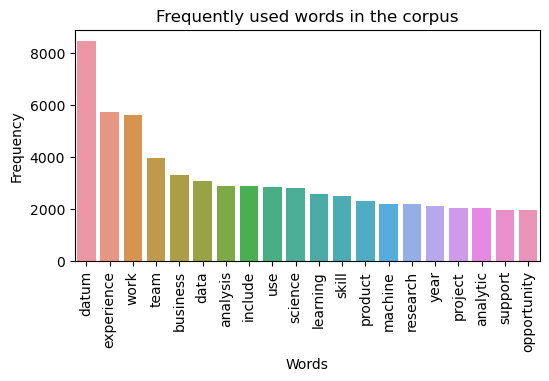

In [68]:
gen_word_freq_plot(preprocessed_words)

### Word Cloud

In [69]:
def gen_word_cloud(words):   
    corpus_text = ' '.join(words)

    # Generate word cloud from the corpus
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='white', 
                         ).generate(corpus_text)

    # Create the plot
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud in the corpus')
    plt.axis('off')
    plt.show()

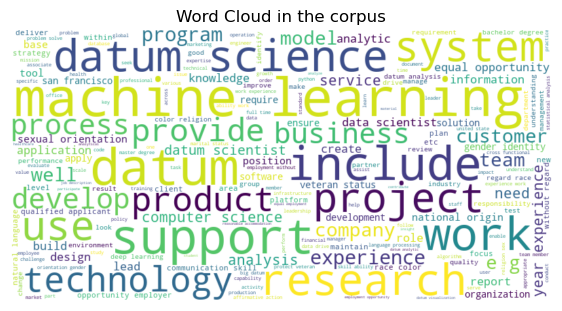

In [70]:
gen_word_cloud(preprocessed_words)

### Analysis of length of the job postings

In [71]:
def gen_len_plot(job_postings_len):

    print(f'Minimum length of the job postings in this corpus: {job_postings_len.min()}')
    print(f'Maximum length of the job postings in this corpus: {job_postings_len.max()}')    
    # Create a figure and axes with desired figsize
    fig, ax = plt.subplots(figsize=(4, 3))

    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of length of the job postings in this corpus')

    sns.histplot(job_postings_len, kde=True, ax=ax)    

In [72]:
# Calculate text lengths
job_postings['pre_processed_text_len'] = job_postings['pre_processed'].str.len()

Minimum length of the job postings in this corpus: 45
Maximum length of the job postings in this corpus: 13386


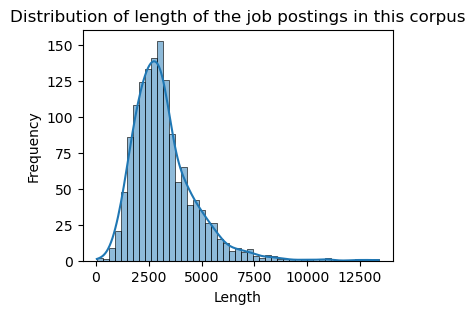

In [73]:
gen_len_plot(job_postings['pre_processed_text_len'])

In [74]:
job_postings[job_postings['pre_processed_text_len'] == 47]

Empty DataFrame
Columns: [file_name, job_desc, pre_processed, pre_processed_text_len]
Index: []

In [75]:
job_postings.loc[35].job_desc

'Director of Econometric Modeling - External Careers'

In [76]:
job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   file_name               1408 non-null   object
 1   job_desc                1408 non-null   object
 2   pre_processed           1408 non-null   object
 3   pre_processed_text_len  1408 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


### Unsupervised Learning

### Word2Vec, PCA and K-Means

In [77]:
# Get the vector representation of the given job description.
def get_job_desc_vector(desc, model):
    # Remove any words not in the model's vocabulary
    words = [word.lower() for word in desc.split() if word.lower() in model.wv.key_to_index]

    # None of the words in the title found in the vocabulary
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Return the mean of the embeddings of the words in the desc
    return np.mean([model.wv[word] for word in words], axis=0)

In [78]:
# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=job_postings['pre_processed'].values, 
                          vector_size=2000, 
                          window=7, 
                          min_count=6, 
                          workers=4, 
                          sg=0)

In [79]:
# Get the vector representations of all the job descriptions
job_desc_vectors = np.array(
    [get_job_desc_vector(job_desc, word2vec_model) for job_desc in job_postings['pre_processed']])

In [80]:
max_value = 10
components = range(1, max_value+1, 2)

exp_var = []

# Find the optimal number of components for dimensionality reduction.
for comp in components:
    pca = PCA(n_components=comp)
    pca.fit(job_desc_vectors)
    var_exp = pca.explained_variance_ratio_.sum()
    exp_var.append(var_exp)

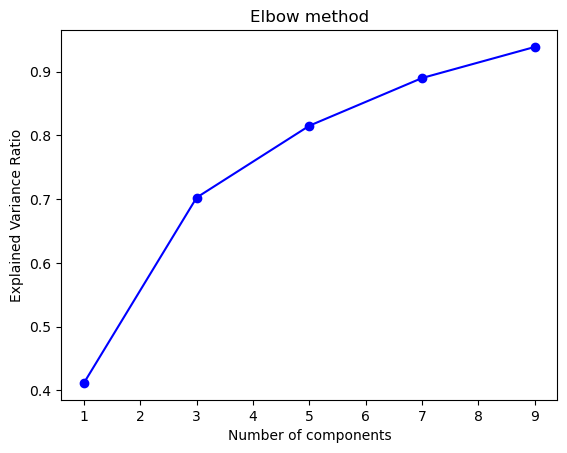

In [81]:
plt.plot(components, exp_var, 'bo-')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow method')
plt.show()

In [82]:
# Perform PCA
pca = PCA(n_components=9)
result = pca.fit_transform(job_desc_vectors)

In [83]:
sil = []
for k in range(2, 20, 5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(result)
    preds = kmeans.predict(result)
    sil.append(silhouette_score(result, preds, metric = 'cosine'))

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

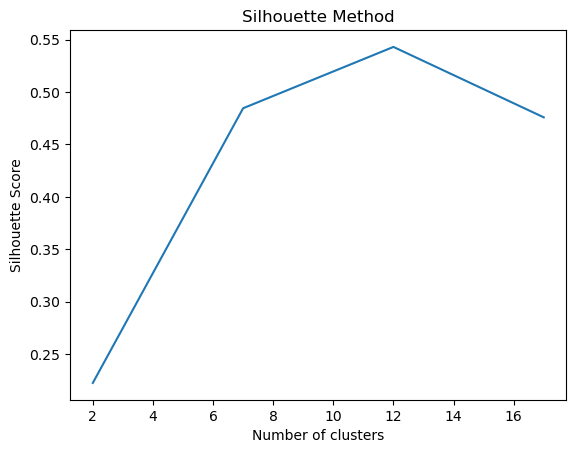

In [84]:
plt.plot(range(2, 20, 5), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [85]:
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(result)
labels = kmeans.predict(result)

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


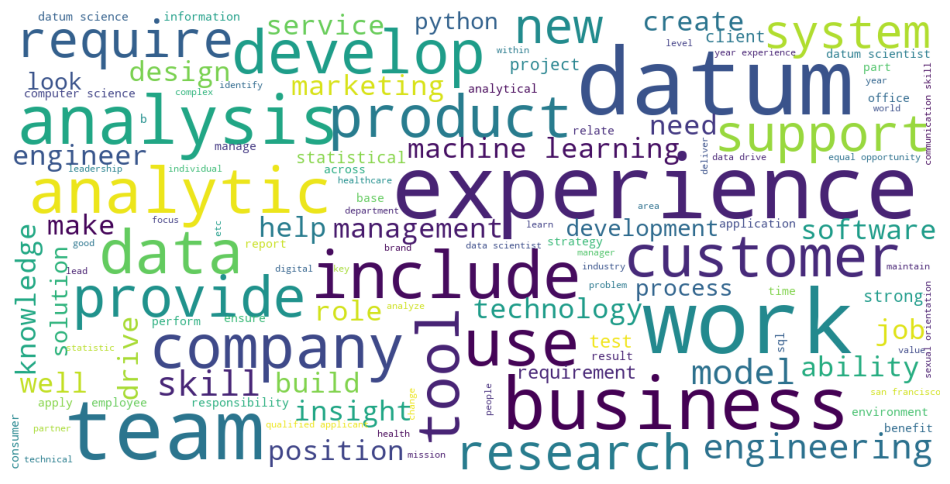

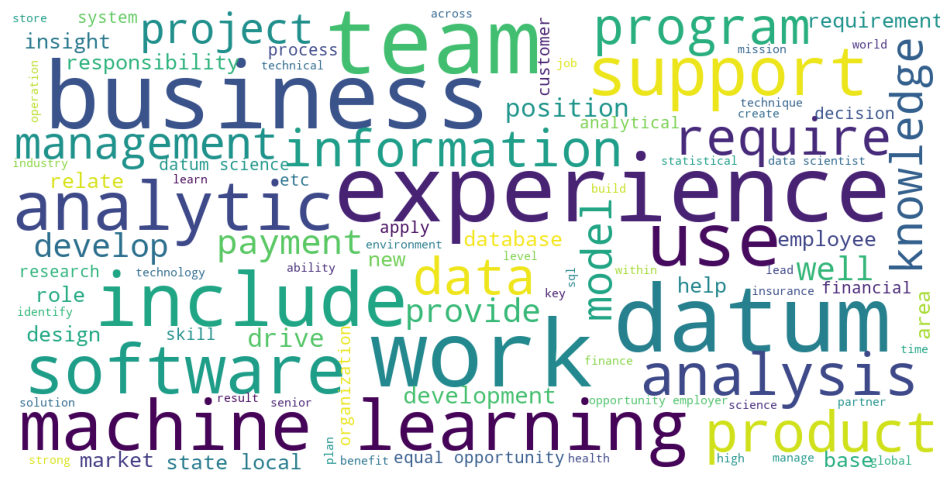

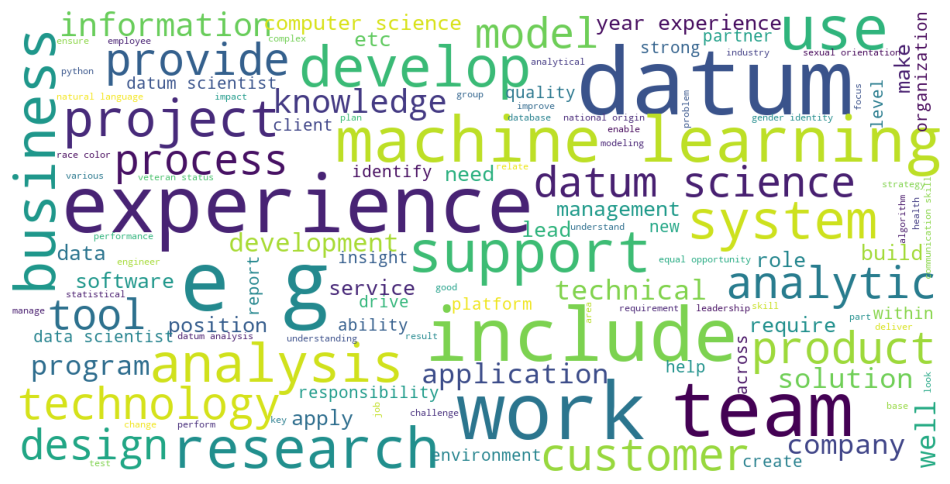

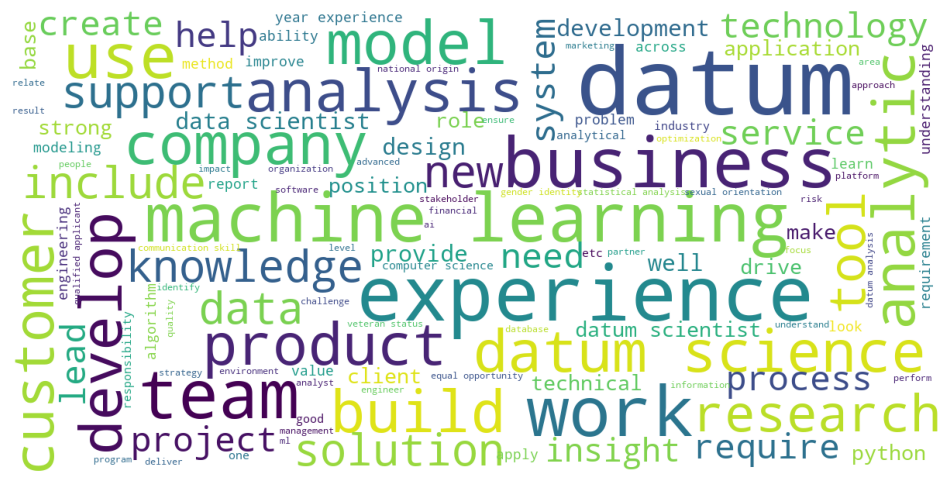

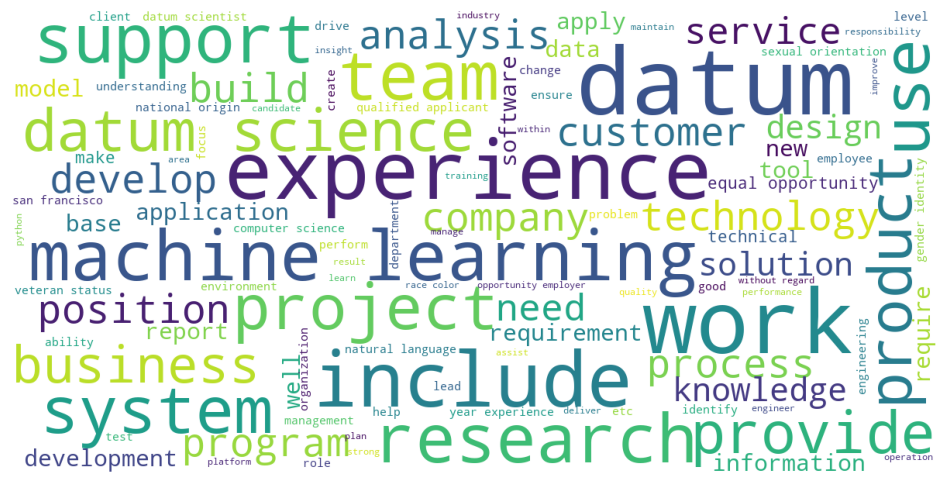

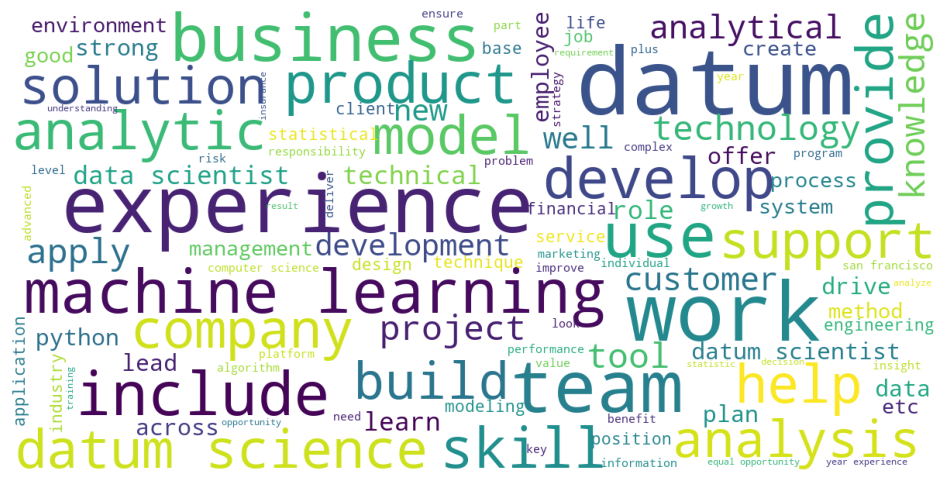

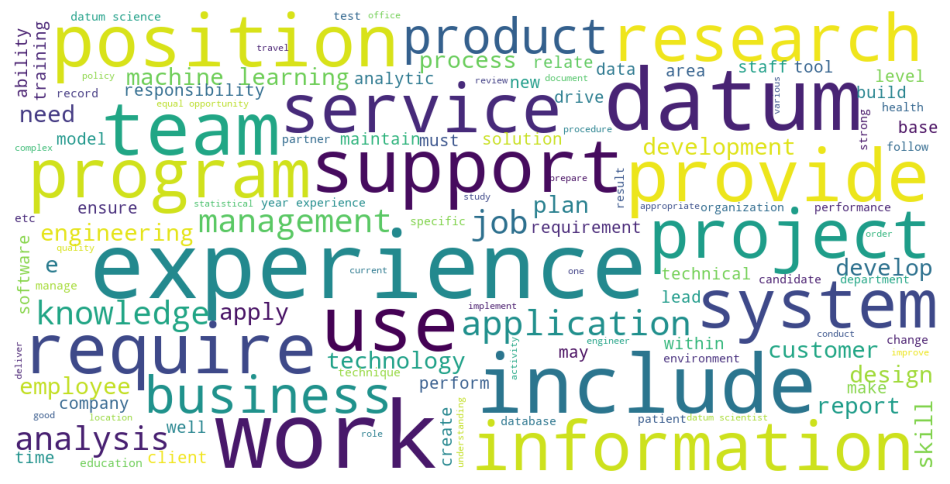

In [86]:
# Additional code to generate word clouds
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# Generate word clouds for each cluster
for i in range(num_clusters):
    show_wordcloud(' '.join(job_postings['pre_processed'].values[labels == i]))
    print()


In [87]:
# Add cluster labels to the dataset
job_postings['cluster_label_method_1'] = labels

In [88]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Data Scientist - Beavercreek, OH Data Scientis...   
1  00321a48d04fe754.html  Data Scientist - Seattle, WA 98101 Are you int...   
2  0079c11b2611349f.html  Data Scientist - Newark, CA Data Scientist New...   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA HOW YOU C...   

                                       pre_processed  pre_processed_text_len  \
0  data scientist beavercreek data scientist posi...                    1717   
1  datum scientist seattle interested part artifi...                    2286   
2  data scientist newark data scientist newark fu...                    2005   
3  patient care assistant pca med surg fayette al...                    1827   
4  data manager analyst oakland contribute resear...                    3931   

   cluster_label_method_1  
0                       3  
1                       4  
2                       2  
3                       4  
4                       1

In [89]:
job_postings[job_postings['cluster_label_method_1'] == 1].sample(5)

file_name  \
713   7ba056b7c3fbf8e7.html   
246   28c58e220f123695.html   
120   1661aa9d550a0fbf.html   
1104  c49bf5a9b76b6943.html   
515   57db65d33020166f.html   

                                               job_desc  \
713   Data Scientist - New York, NY 10011 7Park Data...   
246   Senior Data Scientist - Mountain View, CA 9403...   
120   Data Scientist 2 or 3 - McLean, VA Are you mot...   
1104  Senior Software Airworthiness Engineer (2019-0...   
515   Market Data Business Analyst - New York, NY 10...   

                                          pre_processed  \
713   datum scientist new york 7park datum vista equ...   
246   senior datum scientist mountain view like work...   
120   datum scientist mclean motivated work environm...   
1104  senior software airworthiness engineer d177 hu...   
515   market data business analyst new york market d...   

      pre_processed_text_len  cluster_label_method_1  
713                     2938                       1  
246                     3136                       1  
120                     2535                       1  
1104                    2783                       1  
515                     2076                       1

### Doc2Vec, PCA and K-Means

In [90]:
# Prepare data for Doc2Vec
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(job_postings['pre_processed'].values)]

In [91]:
# Train the Doc2Vec model
doc2vec_model = Doc2Vec(tagged_data, vector_size=700, window=5, 
                        min_count=5, workers=4)

In [92]:
# Get the vector for each job description
job_desc_vectors = [doc2vec_model.dv[str(i)] for i in range(len(job_postings['pre_processed'].values))]

In [93]:
max_value = 15
components = range(1, max_value+1, 2)

exp_var = []

# Find the optimal number of components for dimensionality reduction.
for comp in components:
    pca = PCA(n_components=comp)
    pca.fit(job_desc_vectors)
    var_exp = pca.explained_variance_ratio_.sum()
    exp_var.append(var_exp)

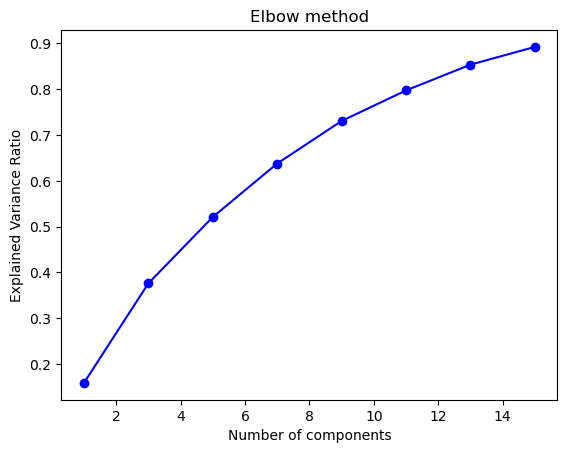

In [94]:
plt.plot(components, exp_var, 'bo-')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow method')
plt.show()

In [95]:
# Perform PCA
pca = PCA(n_components=15)
result = pca.fit_transform(job_desc_vectors)

In [96]:
sil = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(result)
    preds = kmeans.predict(result)
    sil.append(silhouette_score(result, preds, metric = 'cosine'))

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

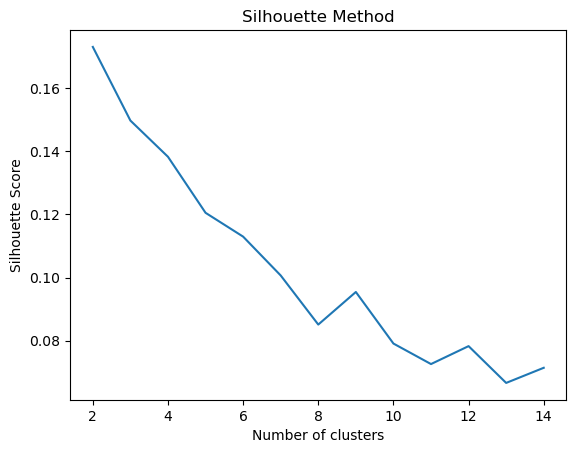

In [97]:
plt.plot(range(2, 15), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [98]:
num_clusters = 2

In [99]:
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(result)
labels = kmeans.predict(result)

C:\Users\subbu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


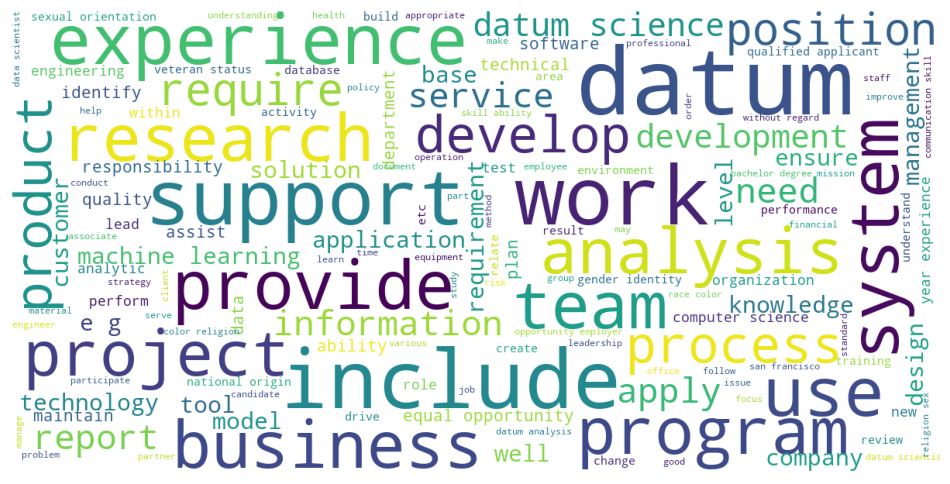

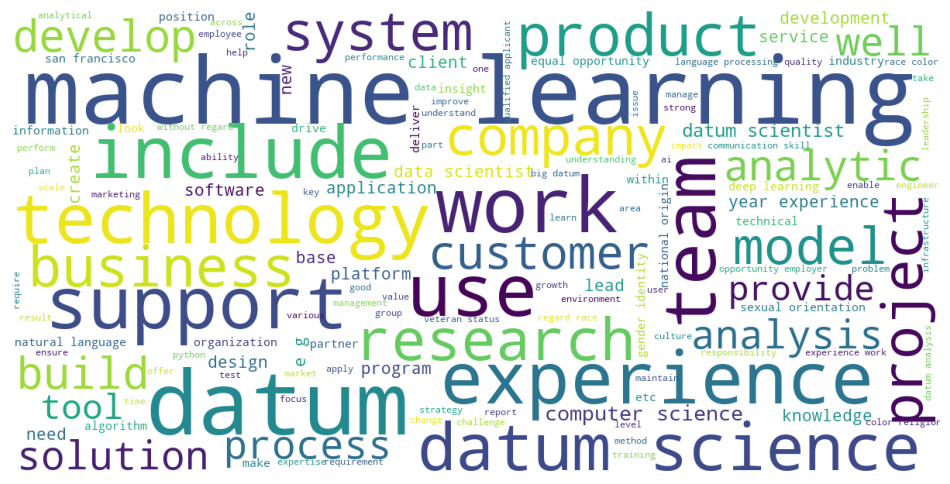

In [100]:
# Generate word clouds for each cluster
for i in range(num_clusters):
    show_wordcloud(' '.join(job_postings['pre_processed'].values[labels == i]))
    print()


In [101]:
# Add cluster labels to the dataset
job_postings['cluster_label_method_2'] = labels

#### Top2Vec and Clustering

In [123]:
job_descriptions = job_postings['pre_processed'].values

In [133]:
# Train a Top2Vec model
model = Top2Vec(documents=job_descriptions,
                speed="learn",
                min_count=100,
                workers=4)


2023-06-19 17:32:20,649 - top2vec - INFO - Pre-processing documents for training
2023-06-19 17:32:22,101 - top2vec - INFO - Creating joint document/word embedding
2023-06-19 17:32:39,237 - top2vec - INFO - Creating lower dimension embedding of documents
2023-06-19 17:32:42,695 - top2vec - INFO - Finding dense areas of documents
2023-06-19 17:32:42,739 - top2vec - INFO - Finding topics


In [134]:
# Get the number of detected topics (clusters)
num_topics = model.get_num_topics()
print(f'Number of topics: {num_topics}')

Number of topics: 6


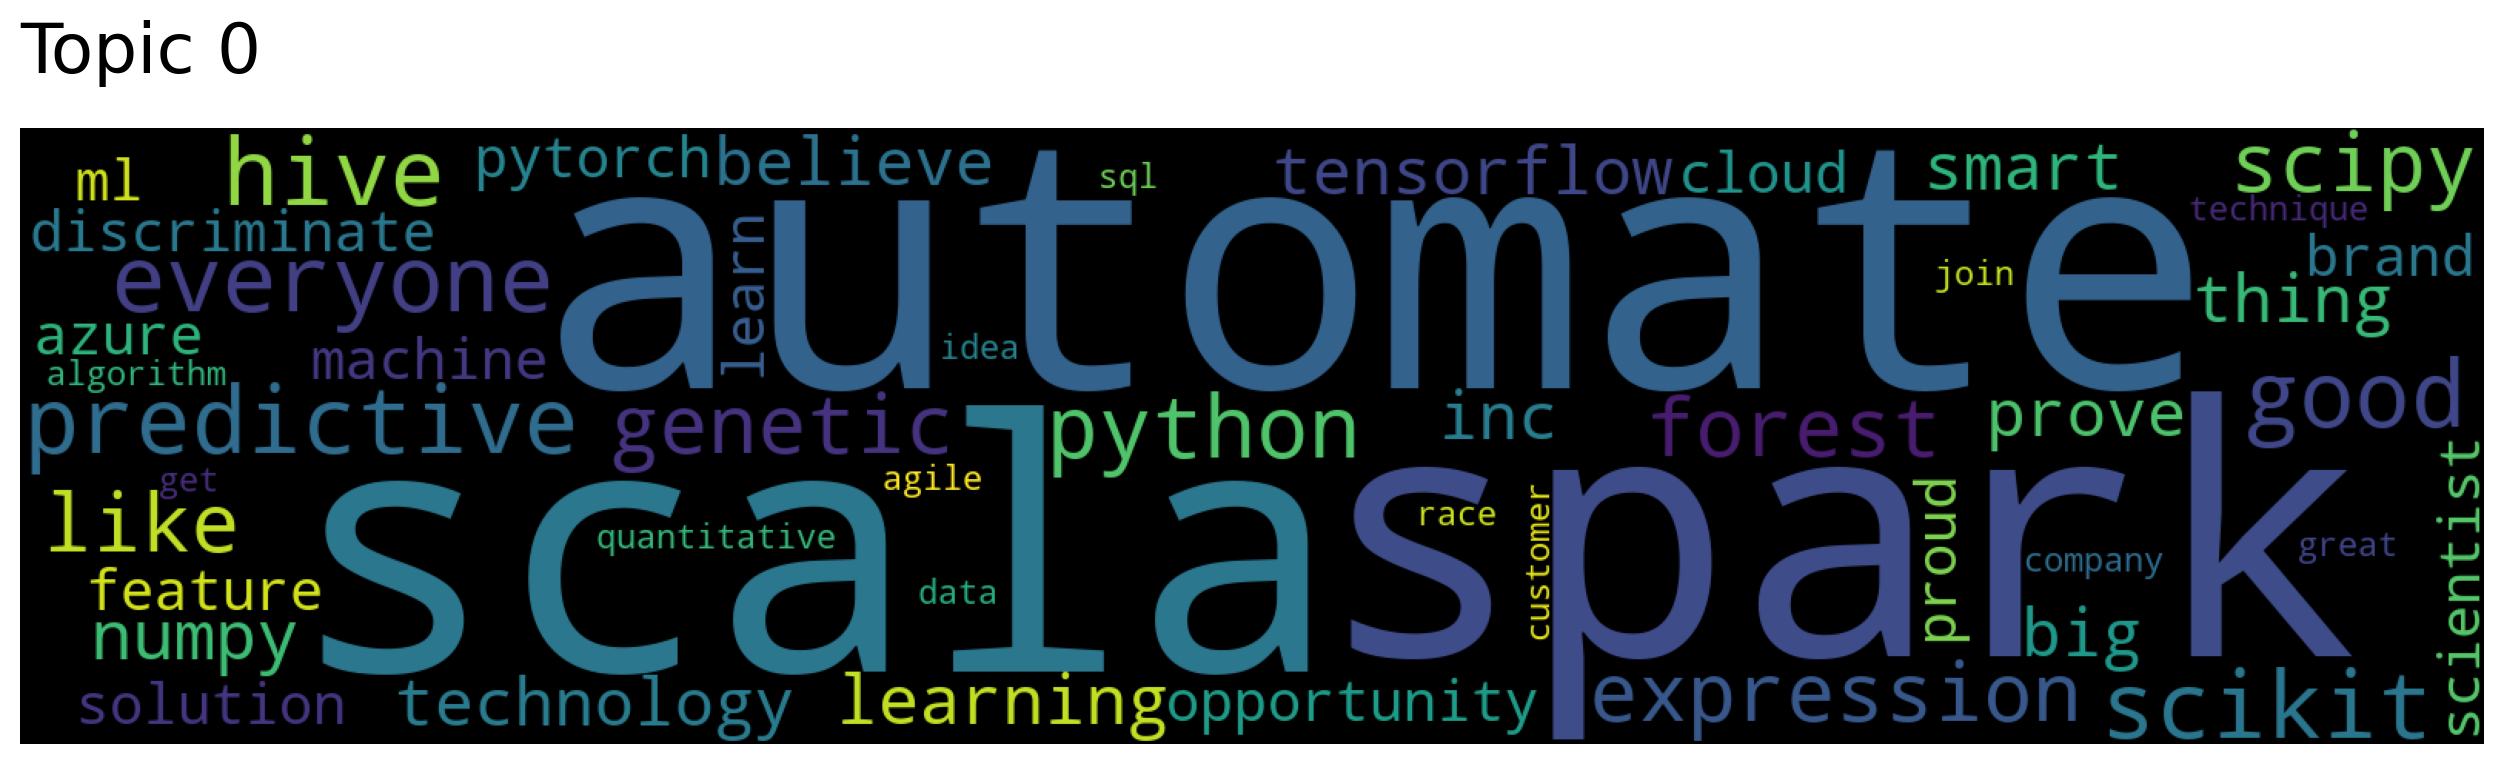

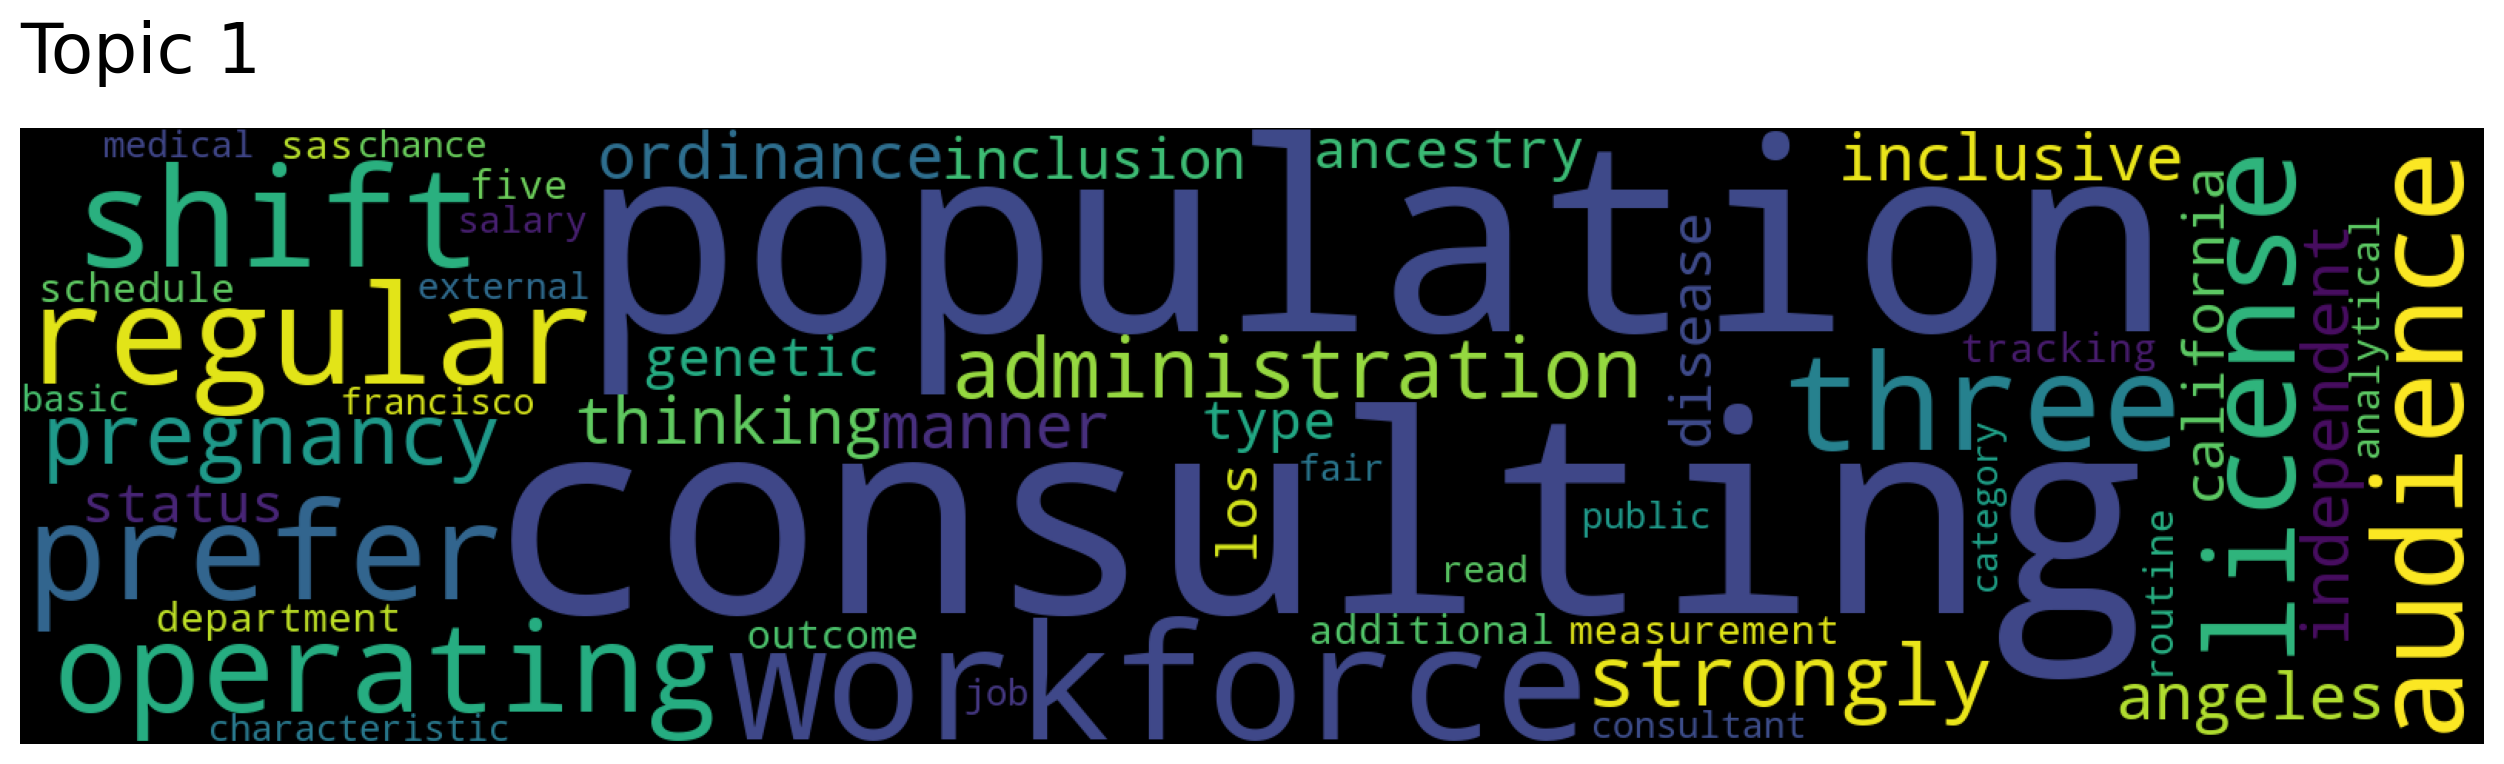

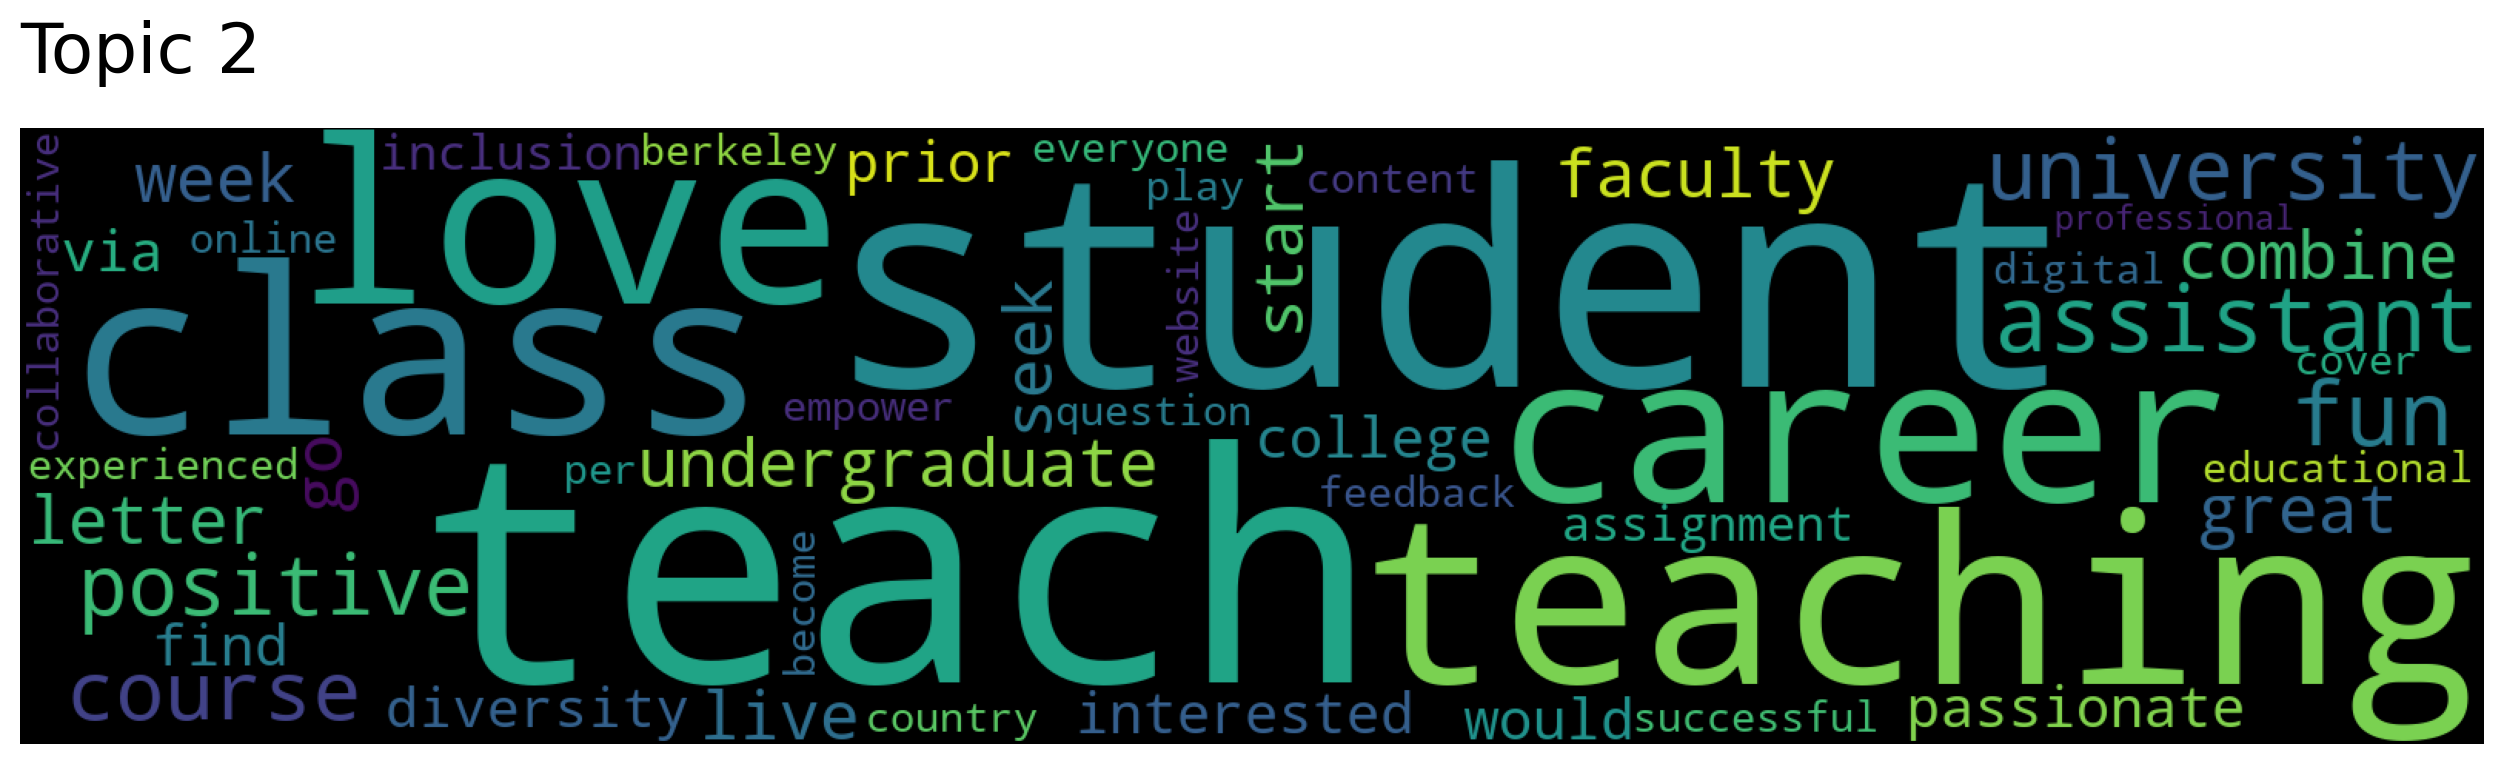

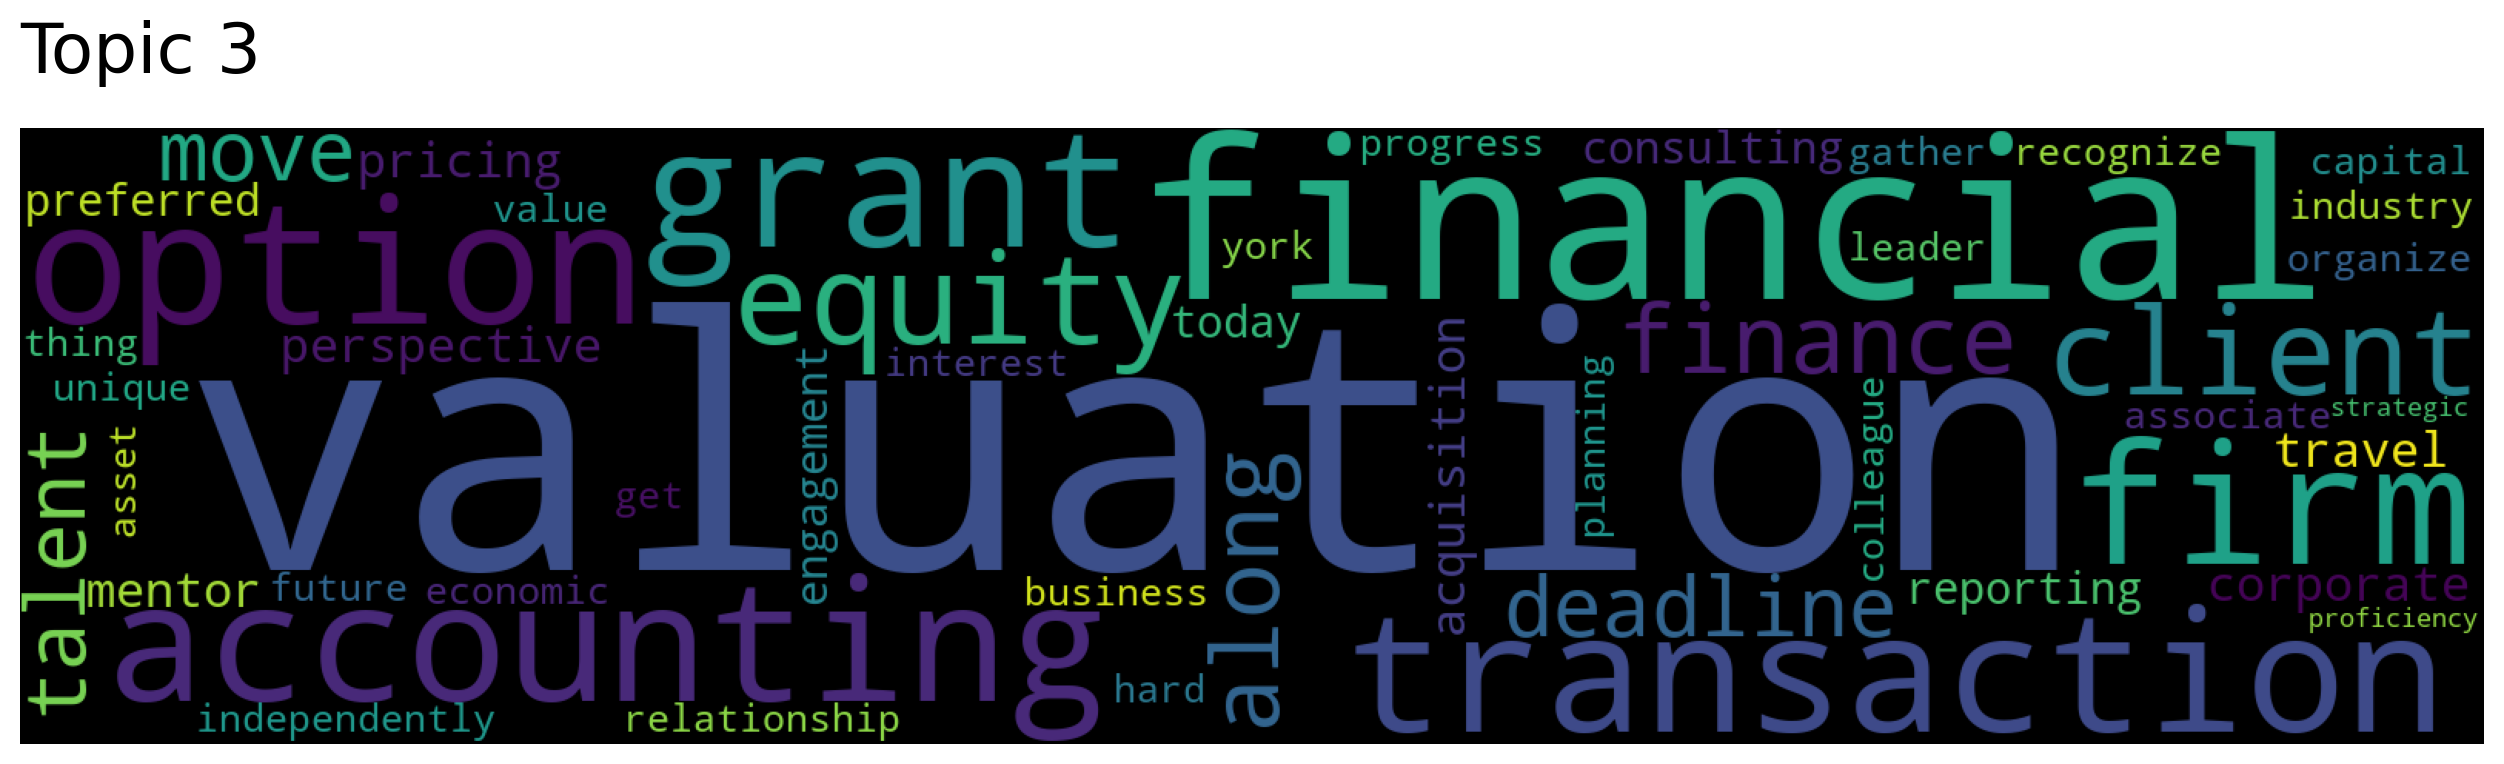

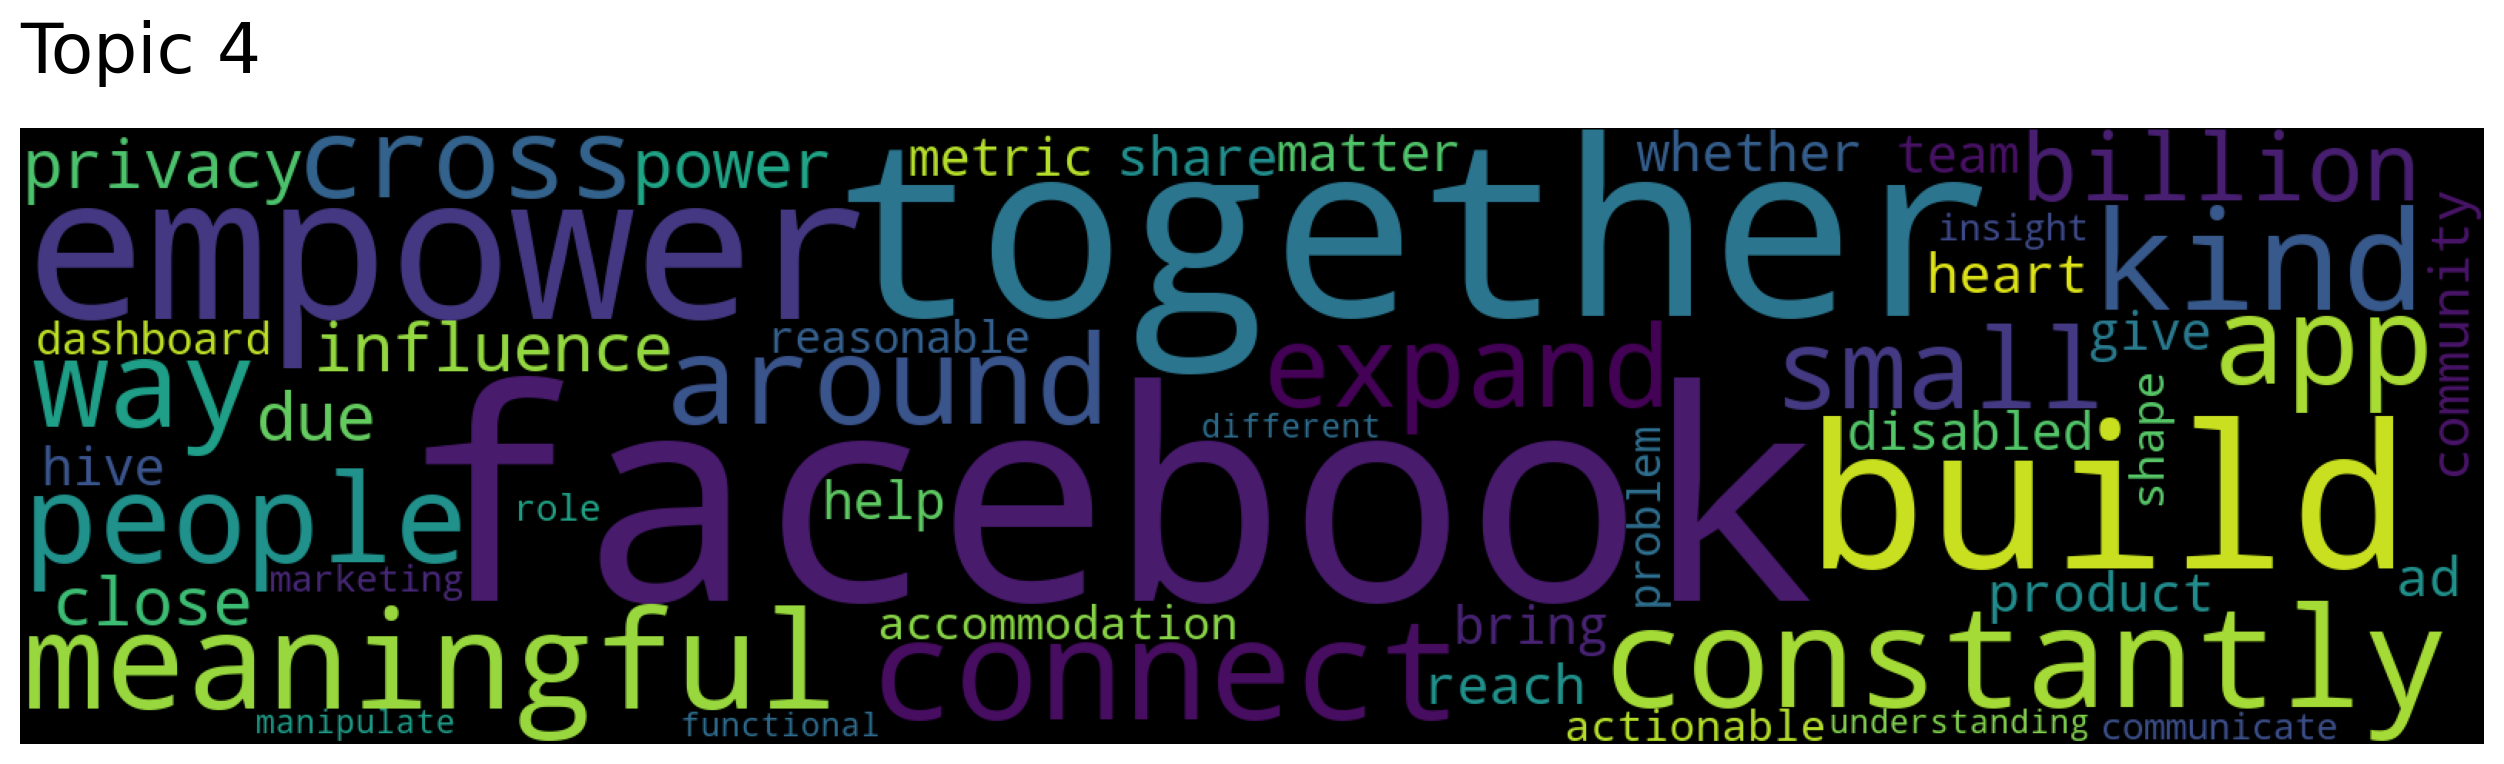

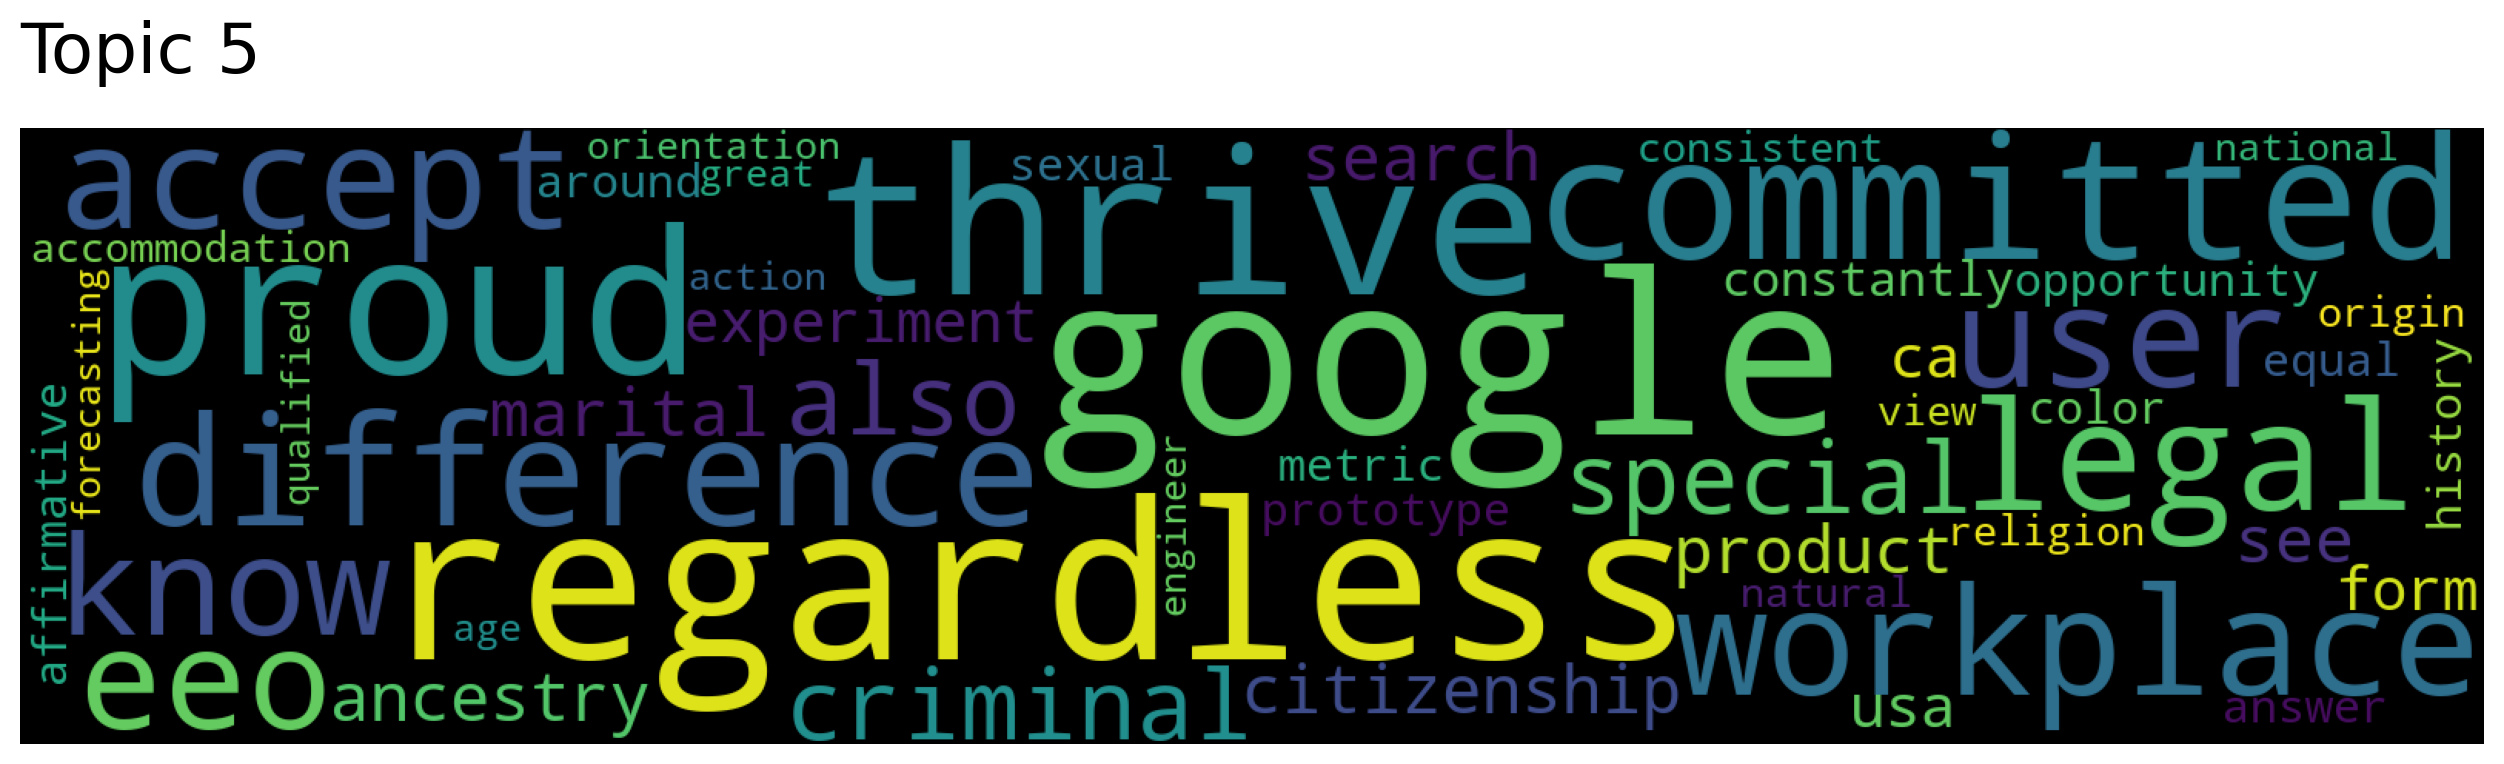

In [135]:
for i in range(num_topics):
    model.generate_topic_wordcloud(i)

In [136]:
# Topics relevant to data science core soft skills like scipy, sql, pandas, keras, tensorflow
model.search_documents_by_topic(0, num_docs=4)

(array(['data scientist shreveport romph pou typical advertising marketing agency also play number culture philosophy datum thing create love collaboration let team member shine want client win dig client datum well understanding create proprietary scorpio system industry leader average day day different mix project week come go day either way load never stale work find answer typical responsibility mine analyze datum company database drive optimization improvement product development marketing technique business strategiesmaintain improve contribute company data science code basekeep code base date run smoothlydevelop custom algorithm run production environmentanalyze marketing campaign result present conclusion managementwork stakeholder throughout organization identify opportunity leverage company datum drive business solutionsassess effectiveness accuracy new datum source datum gathering techniquesdesired qualification solid understanding variety statistical technique concept proba

In [144]:
# Topics relevant to data analyst jobs
model.search_documents_by_topic(1, num_docs=6)

(array(['senior consulting datum analyst sas r python oakland general supervision position exist assist organization make strategic data relate decision analyze manipulate tracking internally manage report datum position function senior analyst high level statistical analytic programmer essential function design enhance databasesdesign effective user friendly menu systemsdevelop accurate easy read useful information reportsdesign generate tracking monitoring toolsparticipate development outcome process measure include technical specification enable population measurement guideline implementation evaluationtest complex statistical routine use macro vendor software software write self otherstest maintain datum integritymay assist sophisticated statistical model forecasting tool use databasesassist definition complex multi dimensional healthcare issue develop time table process decision makingmay translate need issue idea effective strategy action plansmay formulate specific implementatio

In [139]:
# Topics relevant to instructor or teaching assistant
model.search_documents_by_topic(2, num_docs=8)

(array(['data analytic instructor university st louis st louis trilogy education partner university offer program web development data analytic ux ui design cybersecurity platform combine market drive curriculum robust career service multinational community university instructor employer prepare adult learner career digital economy program existence since since launch additional class across nation hire instructor teach assistant support student job look experienced data analyst teach part time data analytic visualization class university st louis instructor essential piece student experience must bring positive attitude able infuse empathy support encouragement fun classroom instructor need ability deliver lesson plan teach across country time share professional experience industry insight student data analytic visualization program many company big datum solution problem big datum problem data analytic visualization course provide learner knowledge skill expertise turn datum insight 

In [140]:
# Topics relevant to finance domain
model.search_documents_by_topic(3, num_docs=4)

(array(['financial advisory valuation service senior associate los angeles valuation service senior associate serve key member rsm valuation service consult team take substantial responsibility perform multiple business valuation financial advisory engagement simultaneously business valuation team perform valuation business entity intellectual property intangible asset common preferred stock security along partnership interest private debt instrument option warrant derivative product service provide assist client merger acquisition disposition taxation planning compliance financial reporting bankruptcy reorganization litigation dispute resolution strategic planning also support assurance tax client pursuant valuation need basic qualification bachelor degree finance accounting relate area study2 year business valuation experience preferably global national firm environment proficiency officeexcellent financial modeling write skillsability travel need request preferred qualification asa 

In [141]:
# Topics relevant to ds jobs in Facebook
model.search_documents_by_topic(4, num_docs=8)

(array(['data scientist analytic community integrity menlo park facebook mission give people power build community bring world close together family app service build different kind company connect billion people around world give way share matter help bring people close together whether create new product help small business expand reach people facebook builder heart global team constantly iterate solve problem work together empower people around world build community connect meaningful way together help people build strong community getting start mission community integrity minimize bad experience people facebook build reporting interface classifier tool facilitate human review checkpoint help identify remediate offensive content abusive behavior role focus enforcement tooling platform currently single platform leverage human review another take action content profile page group performance complex system critical success integrity effort inability effectively review action problemat

In [143]:
# Topics relevant to location based ds jobs
model.search_documents_by_topic(5, num_docs=8)

(array(['data engineer gtech user product mountain view note apply position application automatically submit follow location mountain view ca usa boulder co usa minimum qualification bachelor degree computer science equivalent practical experience3 year code experience general purpose programming language ie python java c experience datum processing use traditional distribute system e g hadoop spark dataflow airflow experience design datum model datum warehouse experience sql nosql database management system prefer qualification advanced degree engineering technical scientific field study equivalent practical experienceexperience writing maintain etls operate variety structured unstructured sourcesexperience unix gnu linux systemsattention detail excellent organizational interpersonal analytical communication skillsabout job gtech user product team gup mission help user get google represent voice google user many partner globally share insight large google organization enable exception

In [145]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [146]:
job_postings['cluster_label_method_3'] = 0

In [147]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Data Scientist - Beavercreek, OH Data Scientis...   
1  00321a48d04fe754.html  Data Scientist - Seattle, WA 98101 Are you int...   
2  0079c11b2611349f.html  Data Scientist - Newark, CA Data Scientist New...   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA HOW YOU C...   

                                       pre_processed  pre_processed_text_len  \
0  data scientist beavercreek data scientist posi...                    1717   
1  datum scientist seattle interested part artifi...                    2286   
2  data scientist newark data scientist newark fu...                    2005   
3  patient care assistant pca med surg fayette al...                    1827   
4  data manager analyst oakland contribute resear...                    3931   

   cluster_label_method_1  cluster_label_method_2  cluster_label_method_3  
0                       3                       0                       0  
1                       4                       1                       0  
2                       2                       1                       0  
3                       4                       0                       0  
4                       1                       1                       0

In [148]:
# Then, for each topic, get the documents (job descriptions) that are most similar to it
for topic, size in zip(topic_nums, topic_sizes):
    topic_documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic, num_docs=size)
    print(f'Topic {topic}:')
    print(document_ids)
    job_postings.loc[document_ids, 'cluster_label_method_3'] = topic

Topic 0:
[ 848  858  941  520  817  906  190 1097  740  638 1223  654  111  440
  294 1251  789  275 1128 1166  427 1055  181 1184  939  118  322  652
  869  551   21  870 1198   50  232  759 1269   14  936  976   38  543
  315 1391    2   64  369  881  378  504 1185  676 1008  184    5 1115
  286  720 1025  357  571 1117  957   39 1264  210 1030  514  166  821
  188  899 1201  470  640  893  103  953  689  586   45 1023  238  242
  715  919  854  860 1389 1193  679  528  381  248 1242  159  710  731
  607 1217  158  644  916  949  705  816 1156  506  981  363  567  942
  325 1112  857 1069  622  281  333  896  155  484  388  593 1255   92
  713 1379  425  503  733  682  292 1109  420  517 1020  728 1318 1110
  222 1344  694  648  443  557  163 1369    1 1036  934  800  727  697
  904 1280 1296  589   33   22   70  273 1287   89  156  339  600  659
  801  453  804  959  245 1310  313 1317   15  905  555  805  955  249
  304  834  497  263  434  993  464 1078   17  265   12  442  160 11

In [149]:
job_postings.head()

file_name                                           job_desc  \
0  001b92395ed0fb62.html  Data Scientist - Beavercreek, OH Data Scientis...   
1  00321a48d04fe754.html  Data Scientist - Seattle, WA 98101 Are you int...   
2  0079c11b2611349f.html  Data Scientist - Newark, CA Data Scientist New...   
3  007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayet...   
4  00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA HOW YOU C...   

                                       pre_processed  pre_processed_text_len  \
0  data scientist beavercreek data scientist posi...                    1717   
1  datum scientist seattle interested part artifi...                    2286   
2  data scientist newark data scientist newark fu...                    2005   
3  patient care assistant pca med surg fayette al...                    1827   
4  data manager analyst oakland contribute resear...                    3931   

   cluster_label_method_1  cluster_label_method_2  cluster_label_method_3  
0                       3                       0                       0  
1                       4                       1                       0  
2                       2                       1                       0  
3                       4                       0                       1  
4                       1                       1                       0

### Checking for the topic assigned by top2vec model

In [152]:
document = "Experience\n\n1. Developed probability simulations using NumPy.\n2. Assessed online ad-clicks for statistical significance using Permutation testing.\
\n3. Analyzed disease outbreaks using common clustering algorithms.\n\nAdditional Skills\n\n\
1. Data visualization using Matplotlib.\n\
2. Statistical analysis using SciPy.\n\
3. Processing structured tables using Pandas.\n\
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.\n\
5. Extracting locations from text using GeonamesCache.\n\
6. Location analysis and visualization using GeonamesCache and Basemap.\n\
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.\n\
8. NLP analysis and text topic detection using Scikit-Learn."

In [154]:
preprocessed_doc = preprocess_text(document)
preprocessed_doc

'experience develop probability simulation use numpy assess online ad click statistical significance use permutation testing analyze disease outbreak use common clustering algorithm additional skill datum visualization use matplotlib statistical analysis use scipy process structured table use panda execute k means clustering dbscan clustering use scikit learn extracting location text use geonamescache location analysis visualization use geonamescache basemap dimensionality reduction pca svd use scikit learn nlp analysis text topic detection use scikit learn'

In [170]:
# query topics based on given text input
topic_words, word_scores, topic_scores, topic_nums = model.query_topics(preprocessed_doc, num_topics=1)

In [171]:
topic_nums

array([0], dtype=int64)

In [172]:
topic_words

[array(['scala', 'automate', 'spark', 'predictive', 'everyone', 'hive',
        'good', 'scikit', 'python', 'expression', 'forest', 'like',
        'scipy', 'genetic', 'learning', 'numpy', 'technology', 'believe',
        'smart', 'thing', 'prove', 'inc', 'tensorflow', 'big',
        'opportunity', 'feature', 'ml', 'pytorch', 'solution',
        'discriminate', 'proud', 'machine', 'brand', 'scientist', 'cloud',
        'azure', 'learn', 'quantitative', 'sql', 'get', 'algorithm',
        'idea', 'data', 'agile', 'join', 'great', 'technique', 'company',
        'customer', 'race'], dtype='<U14')]